In [2]:
import nimfa
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF

In [1]:
def sklearn_decompose_probiotics_signature(X,k):
    nmf_model = NMF(n_components=k, init='random', random_state=0,max_iter=1000)
    nmf_model.fit(X)
    W = nmf_model.transform(X)
    H = nmf_model.components_
    return W,H

def nimfa_decompose_probiotics_signature(X,k):
    nmf_model = nimfa.Nmf(X,rank=k, max_iter=1000)
    nmf_fit = nmf_model()
    W = nmf_fit.basis()
    H = nmf_fit.coef()
    return np.array(W),np.array(H)

def finger_print_proportion(x,w,h):
    """
    Calculate the contribution of each NMF decompose component.
    Args:
        x (np.array): The original matrix.
        w (np.array): The weight matrix of NMF decomposition.
        h (np.array): The coefficient matrix of NMF decomposition

    Returns:
        proportion_matrix (np.array): The contribution of each component.
    """        
    n_finger_print = w.shape[1]
    n_sample = w.shape[0]
    proportion_matrix = np.zeros([n_sample,n_finger_print])

    for i in range(n_sample) :
        total = sum(x[i,:])
        if total == 0 :
            continue
        else :
            for j in range(n_finger_print) :
                ab = sum(np.dot(w[i,j],h[j,:]))# type: ignore       
                proportion_matrix[i,j] = ab / total
        #proportion_matrix[i,-1] = 1 - accum # not calculate residual

    return proportion_matrix

In [6]:
V = np.random.rand(10,4000)
sk_w,sk_h = sklearn_decompose_probiotics_signature(V,10)
nim_w,nim_h = nimfa_decompose_probiotics_signature(V,10)
sk_proportion_m = finger_print_proportion(V,w = sk_w,h=sk_h)
nim_proportion_m = finger_print_proportion(V,w = nim_w,h=nim_h)

In [7]:
nim_h.shape

(10, 4000)

In [129]:
print("W shape of sklearn w is (%d,%d)" % sk_w.shape)
print("W shape of nimfa w is (%d,%d)" % nim_w.shape)

W shape of sklearn w is (5893,10)
W shape of nimfa w is (5893,3)


In [83]:
from matplotlib.lines import Line2D

def evaluate_nmf_component(input_matrix,min_k=2,max_k=10) :
    nmf = nimfa.Nmf(V,rank=max_k, max_iter=200,n_run=10)
    nmf_fit = nmf()
    #evaluation
    evalation = nmf.estimate_rank(rank_range=[x for x in range(min_k,max_k+1)])
    coph_coef = [evalation[x]['cophenetic'] for x in range(min_k,max_k+1)]
    rss = [evalation[x]['rss'] for x in range(min_k,max_k+1)]
    #output the estimation result
    rank_list = list(range(min_k,max_k+1))
    measurements = ['rss','evar','dispersion','cophenetic','kl']
    measurement_table = pd.DataFrame({'Rank' : rank_list})
    for m in measuments :
        measurement_table[m] = [evalation[x][m] for x in rank_list]
    return measurement_table
    '''
    plot_df = measurement_table.melt(id_vars='Rank')
    plot_df.columns = ['Rank','Measurement','value']

    #sns.lineplot(data=plot_df,x="Rank", y="value", hue="Measurement", style= 'Measurement',markers=True)
    g = sns.lineplot(data=measurement_table['Cophenetic_coef'], color="g",markers=True)
    sns.lineplot(data=measurement_table['RSS'], color="b", ax=g.axes.twinx())
    g.legend(handles=[Line2D([], [], marker='_', color="g", label='Cophenetic_coef'), 
                    Line2D([], [], marker='_', color="b", label='RSS')])
    plt.show()
    '''

In [81]:
measurements = ['rss','evar','dispersion','cophenetic','kl']
for m in measurements :
    print("%s : %5.4f" % (m,evalation[2][m]))

rss : 126.3548
evar : 0.8454
dispersion : 0.9590
cophenetic : 0.9988
kl : 883.4665


In [84]:
measurement_table = evaluate_nmf_component(V)

In [95]:
def plot_nmf_evaluation(measurement_table,measurement_1 = 'cophenetic',measurement_2 = 'rss') :
    plt.figure(figsize=(8,5))
    g = sns.lineplot(data=measurement_table,x ='Rank',y=measurement_1, color="orange",marker='o')
    sns.lineplot(data=measurement_table,x = 'Rank',y=measurement_2, ax=g.axes.twinx(),marker='o')
    g.legend(handles=[Line2D([], [], marker='o', color="orange", label=measurement_1), 
                    Line2D([], [], marker='o', label=measurement_2)])
    plt.show()


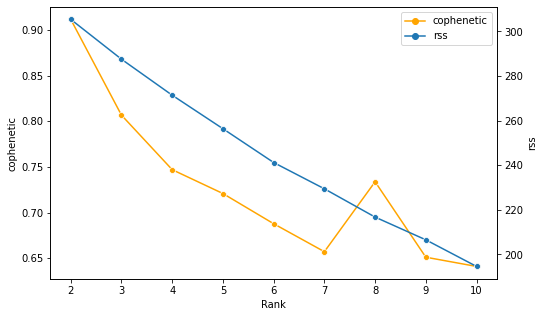

In [96]:
plot_nmf_evaluation(measurement_table=measurement_table)

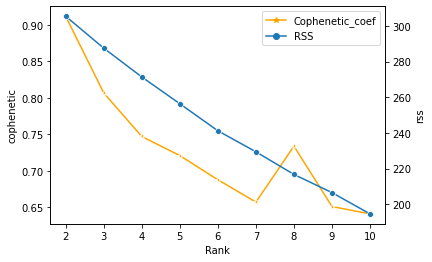

In [85]:
g = sns.lineplot(data=measurement_table,x = 'Rank',y='cophenetic', color="orange",marker='*')
sns.lineplot(data=measurement_table,x = 'Rank',y='rss', ax=g.axes.twinx(),marker='o')
g.legend(handles=[Line2D([], [], marker='*', color="orange", label='Cophenetic_coef'), 
                Line2D([], [], marker='o', label='RSS')])
plt.show()